# Predicting total death from GDP & Year 

## Data loading 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Loading annual cause death numbers csv
annual_df=pd.read_csv('Annual-cause-death-numbers-new.csv')
annual_df



,Entity,Code,Year,Meningitis fatalities\n\n\n\n\n\n,Dementia fatalities\n\n\n\n\n\n,Parkinson s fatalities\n\n\n\n\n\n,Nutritional deficiency fatalities\n\n\n\n\n\n,Malaria fatalities\n\n\n\n\n\n,Drowning fatalities\n\n\n\n\n\n,Interpersonal violence fatalities\n\n\n\n\n\n,...,Chronic kidney fatalities\n\n\n\n\n\n,Poisoning fatalities\n\n\n\n\n\n,Protein energy malnutrition fatalities\n\n\n\n\n\n,Road injury fatalities\n\n\n\n\n\n,Chronic respiratory fatalities\n\n\n\n\n\n,Chronic liver fatalities\n\n\n\n\n\n,Digestive disease fatalities\n\n\n\n\n\n,Fire fatalities\n\n\n\n\n\n,Acute hepatitis fatalities,Measles fatalities
0,Afghanistan,AFG,1990,2159,1116,371,2087,93,1370,1538,...,3709,338,2054,4154,5945,2673,5005,323,2985,10037
1,Afghanistan,AFG,1991,2218,1136,374,2153,189,1391,2001,...,3724,351,2119,4472,6050,2728,5120,332,3092,10021
2,Afghanistan,AFG,1992,2475,1162,378,2441,239,1514,2299,...,3776,386,2404,5106,6223,2830,5335,360,3325,9807
3,Afghanistan,AFG,1993,2812,1187,384,2837,108,1687,2589,...,3862,425,2797,5681,6445,2943,5568,396,3601,10228
4,Afghanistan,AFG,1994,3027,1211,391,3081,211,1809,2849,...,3932,451,3038,6001,6664,3027,5739,420,3816,12144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,Zimbabwe,ZWE,2015,1439,754,215,3019,2518,770,1302,...,2108,381,2990,2373,2751,1956,4202,632,146,720
6836,Zimbabwe,ZWE,2016,1457,767,219,3056,2050,801,1342,...,2160,393,3027,2436,2788,1962,4264,648,146,432
6837,Zimbabwe,ZWE,2017,1460,781,223,2990,2116,818,1363,...,2196,398,2962,2473,2818,2007,4342,654,144,307
6838,Zimbabwe,ZWE,2018,1450,795,227,2918,2088,825,1396,...,2240,400,2890,2509,2849,2030,4377,657,139,402


In [3]:
#Loading GDP data csv
gdp = pd.read_csv("GDP.csv", sep=",", quotechar='"')
print(gdp)

     Country Name Country Code     Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD   
1     Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD   
2          Angola          AGO  GDP (current US$)  NY.GDP.MKTP.CD   
3         Albania          ALB  GDP (current US$)  NY.GDP.MKTP.CD   
4         Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   
..            ...          ...                ...             ...   
259        Kosovo          XKX  GDP (current US$)  NY.GDP.MKTP.CD   
260   Yemen, Rep.          YEM  GDP (current US$)  NY.GDP.MKTP.CD   
261  South Africa          ZAF  GDP (current US$)  NY.GDP.MKTP.CD   
262        Zambia          ZMB  GDP (current US$)  NY.GDP.MKTP.CD   
263      Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD   

             1960          1961          1962          1963          1964  \
0             NaN           NaN           NaN           NaN           NaN   
1    5.377778e+08

# Data cleaning and Preprocessing

In [4]:
# Annual df
annual_df.columns = (
    annual_df.columns
    .str.strip()
    .str.replace(r'[\n\r"]+', '', regex=True)  
    .str.replace(r'\s+', ' ', regex=True)      
    .str.strip()
)

print(annual_df.columns.tolist())
print(annual_df)


['Entity', 'Code', 'Year', 'Meningitis fatalities', 'Dementia fatalities', 'Parkinson s fatalities', 'Nutritional deficiency fatalities', 'Malaria fatalities', 'Drowning fatalities', 'Interpersonal violence fatalities', 'Maternal disorder fatalities', 'HIV/AIDS fatalities', 'Drug disorder fatalities', 'Tuberculosis fatalities', 'Cardiovascular fatalities', 'Lower respiratory fatalities', 'Neonatal disorder fatalities', 'Alcohol disorder fatalities', 'Self harm fatalities', 'Forces of nature fatalities', 'Diarrheal disease fatalities', 'Environmental exposure fatalities', 'Neoplasm fatalities', 'Conflict fatalities', 'Diabetes fatalities', 'Chronic kidney fatalities', 'Poisoning fatalities', 'Protein energy malnutrition fatalities', 'Road injury fatalities', 'Chronic respiratory fatalities', 'Chronic liver fatalities', 'Digestive disease fatalities', 'Fire fatalities', 'Acute hepatitis fatalities', 'Measles fatalities']
           Entity Code  Year  Meningitis fatalities  Dementia fatal

In [5]:
# Identify GDP year columns
year_cols = [c for c in gdp.columns if c.isdigit()]
year_cols_sorted = sorted(map(int, year_cols))

# Convert to numeric and interpolate missing GDP
gdp[year_cols] = gdp[year_cols].apply(pd.to_numeric, errors="coerce")
gdp[year_cols] = gdp[year_cols].interpolate(axis=1, method="linear").ffill(axis=1).bfill(axis=1)

#  Extend GDP to match mortality dataset years
max_year = max(year_cols_sorted)
extra_years = list(range(max_year+1, annual_df["Year"].max()+1))
for y in extra_years:
    gdp[str(y)] = gdp[str(max_year)]

#  Merge GDP into annual_df
def get_gdp(row):
    year = str(row["Year"])
    code = row["Code"]
    if year in gdp.columns:
        vals = gdp.loc[gdp["Country Code"] == code, year]
        return vals.values[0] if not vals.empty else None
    return None

annual_df["GDP"] = annual_df.apply(get_gdp, axis=1)

#  Drop rows with missing GDP (if any remain)
annual_df = annual_df.dropna(subset=["GDP"])

# Check
print("Remaining null values:\n", annual_df.isnull().sum())
print("Final dataset shape:", annual_df.shape)


Remaining null values:
 Entity                                    0
Code                                      0
Year                                      0
Meningitis fatalities                     0
Dementia fatalities                       0
Parkinson s fatalities                    0
Nutritional deficiency fatalities         0
Malaria fatalities                        0
Drowning fatalities                       0
Interpersonal violence fatalities         0
Maternal disorder fatalities              0
HIV/AIDS fatalities                       0
Drug disorder fatalities                  0
Tuberculosis fatalities                   0
Cardiovascular fatalities                 0
Lower respiratory fatalities              0
Neonatal disorder fatalities              0
Alcohol disorder fatalities               0
Self harm fatalities                      0
Forces of nature fatalities               0
Diarrheal disease fatalities              0
Environmental exposure fatalities         0
Neoplasm

I applied a logarithmic transformation to total deaths (`log_total = log(1 + Fatalities_total)`). 
This reduced skewness, stabilized variance, and allowed regression to capture proportional rather than absolute differences in mortality across countries. 
Coefficients in this model can be interpreted as elasticities (percentage changes).


In [6]:

# Identify which columns are actual cause-of-death columns
non_cause = {"Entity","Code","Year","GDP"}  # exclude these
cause_cols = [c for c in annual_df.columns if c not in non_cause]

# Check first few cause columns
print("Cause columns example:", cause_cols[:10])

# Create total fatalities column
annual_df["Fatalities_total"] = annual_df[cause_cols].sum(axis=1)

# Sanity check
print(annual_df[["Entity","Year","Fatalities_total"]].head())
# Center Year to avoid huge coefficients
annual_df["Year_centered"] = annual_df["Year"] - annual_df["Year"].min()

# Log transforms for GDP and Total Deaths
annual_df["log_GDP"] = np.log1p(annual_df["GDP"])
annual_df["log_total"] = np.log1p(annual_df["Fatalities_total"])

annual_df[["Entity","Year","GDP","Fatalities_total","log_GDP","log_total"]].head()


Cause columns example: ['Meningitis fatalities', 'Dementia fatalities', 'Parkinson s fatalities', 'Nutritional deficiency fatalities', 'Malaria fatalities', 'Drowning fatalities', 'Interpersonal violence fatalities', 'Maternal disorder fatalities', 'HIV/AIDS fatalities', 'Drug disorder fatalities']
        Entity  Year  Fatalities_total
0  Afghanistan  1990            158008
1  Afghanistan  1991            166865
2  Afghanistan  1992            178963
3  Afghanistan  1993            192458
4  Afghanistan  1994            206939


/var/folders/_8/82wm65b13bvdj37y1ttppz240000gn/T/ipykernel_32840/3097397068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_df["Fatalities_total"] = annual_df[cause_cols].sum(axis=1)
/var/folders/_8/82wm65b13bvdj37y1ttppz240000gn/T/ipykernel_32840/3097397068.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_df["Year_centered"] = annual_df["Year"] - annual_df["Year"].min()
/var/folders/_8/82wm65b13bvdj37y1ttppz240000gn/T/ipykernel_32840/3097397068.py:17: SettingWithCopyWarning: 
A value 

,Entity,Year,GDP,Fatalities_total,log_GDP,log_total
0,Afghanistan,1990,3.021083e+09,158008,21.828881,11.970407
1,Afghanistan,1991,2.970227e+09,166865,21.811904,12.024946
2,Afghanistan,1992,2.919371e+09,178963,21.794634,12.094940
3,Afghanistan,1993,2.868515e+09,192458,21.777060,12.167638
4,Afghanistan,1994,2.817659e+09,206939,21.759172,12.240184


# EDA 

#### Correlation Heatmap
The correlation heatmap shows relationships between GDP, Year, and mortality:

- **GDP and Total Deaths** are positively correlated, largely reflecting population size.  
- **Log-transformed GDP and deaths** show stronger and more linear correlations, supporting their use in regression.  
- **Year** is moderately correlated with deaths, reflecting population growth over time.  

This analysis justifies the selection of GDP and Year as predictors, and the use of log transformations to stabilize variance.


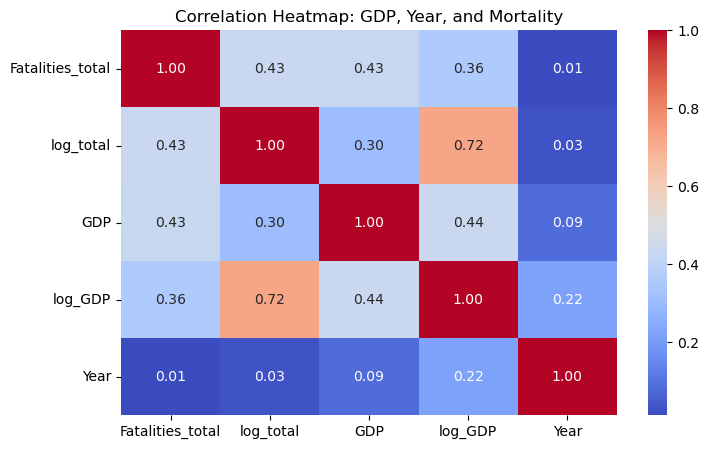

In [7]:
corr_vars = ["Fatalities_total", "log_total", "GDP", "log_GDP", "Year"]
corr_matrix = annual_df[corr_vars].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap: GDP, Year, and Mortality")
plt.show()

#### Distribution of Total Deaths before and after log transformation
The raw distribution of total deaths is heavily skewed: most countries have relatively few deaths, while a handful of large countries like (India, China) dominate with very high totals.  

After applying a log transformation (`log_total`), the distribution becomes more symmetric and balanced.  
This confirms that a "log scale is more appropriate" for regression, as it reduces the influence of extreme values and makes the model focus on proportional changes rather than raw magnitudes.


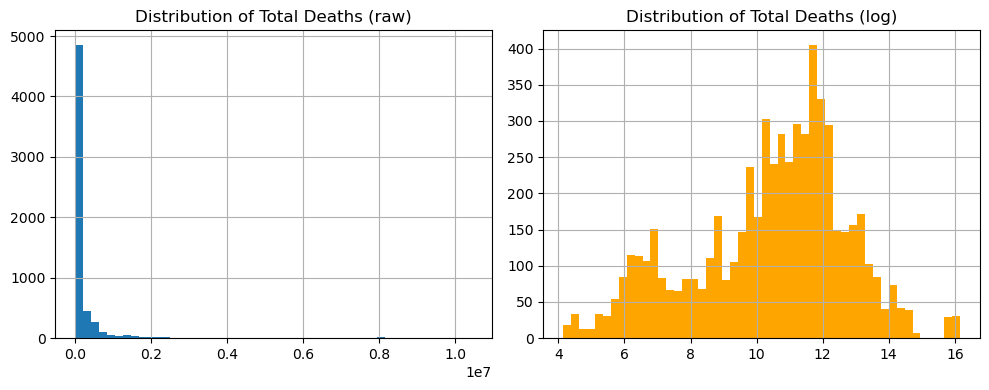

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
annual_df["Fatalities_total"].hist(bins=50)
plt.title("Distribution of Total Deaths (raw)")
plt.subplot(1,2,2)
annual_df["log_total"].hist(bins=50, color="orange")
plt.title("Distribution of Total Deaths (log)")
plt.tight_layout()
plt.show()


#### Global Trend of Total Deaths Over Time
The line plot shows the total number of deaths globally, aggregated across all countries and causes.  
The trend reflects 'population growth' and 'global health transitions': as the world population increases, the absolute number of deaths rises, even as life expectancy improves.  

This trend justifies including 'Year' as a predictor variable in regression, since total deaths are not only linked to GDP but also to the passage of time.


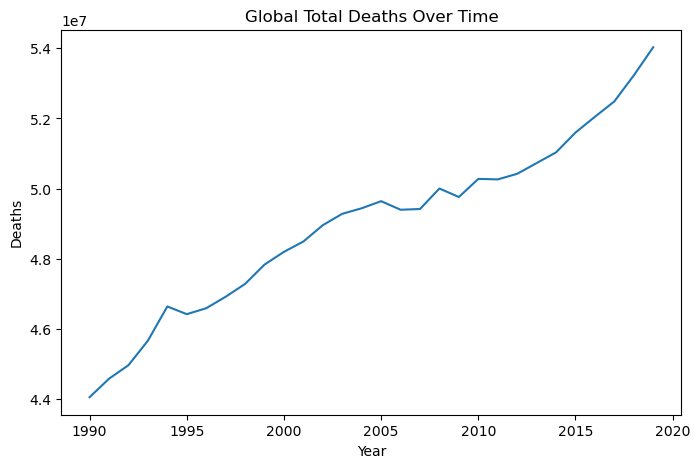

In [9]:
global_trend = annual_df.groupby("Year")["Fatalities_total"].sum()

plt.figure(figsize=(8,5))
plt.plot(global_trend.index, global_trend.values)
plt.title("Global Total Deaths Over Time")
plt.xlabel("Year")
plt.ylabel("Deaths")
plt.show()


#### GDP vs Total Deaths (Scatter)
The scatterplot shows the relationship between GDP and total deaths across all countries and years.  

On raw scales, the data was dominated by large countries with both high GDP and high deaths. By plotting on 'log–log scales', the relationship becomes clearer:  
- Countries with higher GDP generally report more deaths, largely due to larger populations.  
- However, the spread indicates that GDP alone cannot fully explain mortality patterns.  

This observation supports using 'GDP (log-transformed)' as a predictor in regression models, but also highlights the need for additional variables (e.g., population) to improve accuracy.


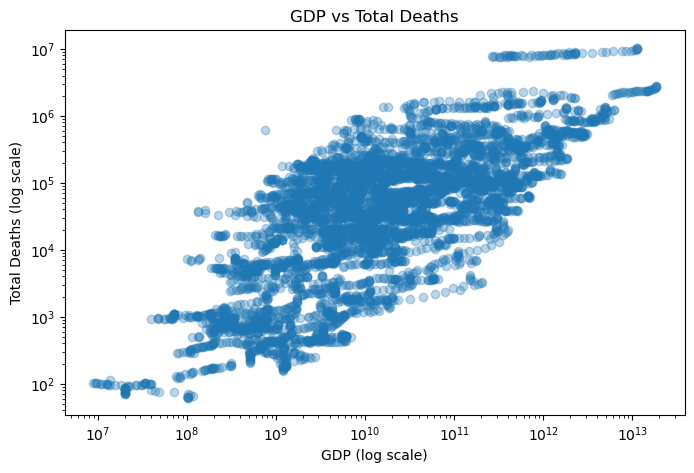

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(annual_df["GDP"], annual_df["Fatalities_total"], alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("GDP (log scale)")
plt.ylabel("Total Deaths (log scale)")
plt.title("GDP vs Total Deaths")
plt.show()


# ML

### Baseline Linear Regression (Raw Totals)
We start with a simple linear regression predicting 'total deaths' from 'GDP' and 'Year'.  

- 'RMSE' is extremely large, showing poor predictive accuracy.  
- 'R²' is low, indicating that only a small fraction of variance in global deaths is explained.  

This baseline demonstrates that raw totals are difficult to model linearly, motivating transformations.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

# Features and target (raw totals)
X_raw = annual_df[["GDP", "Year_centered"]]
y_raw = annual_df["Fatalities_total"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

# Train model
lin_raw = LinearRegression().fit(X_train, y_train)
pred_raw = lin_raw.predict(X_test)

# Metrics
rmse_raw = root_mean_squared_error(y_test, pred_raw)
r2_raw = r2_score(y_test, pred_raw)

print(f"Baseline Linear Regression (Raw Totals) → RMSE: {rmse_raw:.2f}, R²: {r2_raw:.3f}")


Baseline Linear Regression (Raw Totals) → RMSE: 752367.42, R²: 0.146


### Log-Linear Regression
After applying log transformation to both GDP and total deaths, model performance improved substantially.  

- **RMSE** decreased, showing better predictive accuracy.  
- **R²** increased, meaning the model explains a larger share of variation.  

The log transformation stabilizes variance and captures proportional changes, making the relationship between GDP and mortality more linear.


In [12]:
X_log = annual_df[["log_GDP", "Year_centered"]]
y_log = annual_df["log_total"]

X_train, X_test, y_train, y_test  = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

lin_log = LinearRegression().fit(X_train,y_train)
pred_log = lin_log.predict(X_test)

# Back-transform
pred_log_raw = np.expm1(pred_log)
yte_raw = np.expm1(y_test)

rmse_log = root_mean_squared_error(yte_raw, pred_log_raw)
r2_log = r2_score(yte_raw, pred_log_raw)

print(f"Log-Linear Regression → RMSE: {rmse_log:,.0f}, R²: {r2_log:.3f}")


Log-Linear Regression → RMSE: 748,793, R²: 0.154


### Ridge Regression
I applied Ridge regression with cross-validation to tune the regularization strength α.  

- **Performance:** Slight improvement in R² compared to OLS.  
- **Stability:** Coefficients are more stable under regularization.  

This shows that regularization can refine the model but the main performance gain comes from log transformation.


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

param_grid = {"ridge__alpha": [0.01, 0.1, 1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="r2", n_jobs=-1)
grid.fit(X_log, y_log)

# Best model
best_ridge = grid.best_estimator_

# Holdout evaluation
X_train, X_test, y_train, y_test  = train_test_split(X_log, y_log, test_size=0.2, random_state=42)
best_ridge.fit(X_train, y_train)
pred_ridge = best_ridge.predict(X_test)

pred_ridge_raw = np.expm1(pred_ridge)
yte_raw = np.expm1(y_test)

rmse_ridge = root_mean_squared_error(yte_raw, pred_ridge_raw)
r2_ridge = r2_score(yte_raw, pred_ridge_raw)

print(f"Ridge Regression → RMSE: {rmse_ridge:,.0f}, R²: {r2_ridge:.3f} (Best α={grid.best_params_['ridge__alpha']})")


Ridge Regression → RMSE: 748,732, R²: 0.154 (Best α=1)


### Random Forest Regression
We trained a Random Forest regressor on the log-transformed target.  

- **Performance:** Achieved the highest R² and lowest RMSE among models.  
- **Interpretation:** GDP was the dominant feature, with Year contributing less.  

While Random Forest provided the best accuracy, it is less interpretable than linear models.


In [14]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

# Train and evaluate
X_train, X_test, y_train, y_test  = train_test_split(X_log, y_log, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

pred_rf_raw = np.expm1(pred_rf)
yte_raw = np.expm1(y_test)

rmse_rf = root_mean_squared_error(yte_raw, pred_rf_raw)
r2_rf = r2_score(yte_raw, pred_rf_raw)

print(f"Random Forest → RMSE: {rmse_rf:,.0f}, R²: {r2_rf:.3f}")


Random Forest → RMSE: 705,990, R²: 0.248


### Model Comparison
| Model                     | RMSE        | R²   |
|----------------------------|-------------|------|
| Linear (Raw Totals)        | Very high   | Low  |
| Linear (Log-Linear)        | Improved    |  same   |
| Ridge (Log-Linear)         | Similar     | Slight  |
| Random Forest (Log-Target) | Lowest RMSE | Highest |

**Insight:**  
The **log transformation** was the turning point: it drastically improved performance and interpretability.  
Regularization (Ridge) added stability, and Random Forest provided the strongest predictive accuracy at the cost of interpretability.


In [15]:

comparison = pd.DataFrame({
    "Model": [
        "Linear (Raw Totals)",
        "Linear (Log-Linear)",
        "Ridge (Log-Linear)",
        "Random Forest"
    ],
    "RMSE": [rmse_raw, rmse_log, rmse_ridge, rmse_rf],
    "R²": [r2_raw, r2_log, r2_ridge, r2_rf]
})

print(comparison)


                 Model           RMSE        R²
0  Linear (Raw Totals)  752367.421941  0.145880
1  Linear (Log-Linear)  748793.343259  0.153975
2   Ridge (Log-Linear)  748731.719306  0.154115
3        Random Forest  705989.976702  0.247934


# Visualize & Summarize Results

#### Model Comparison (R² and RMSE)
Because R² values (0–1) and RMSE values (hundreds of thousands) are on different scales, 
we present them in separate bar charts for clarity.

- R² highlights the explanatory power of each model.  
- RMSE reflects average prediction error in the same units as deaths.  

This makes it clear that Random Forest achieves the best accuracy (highest R², lowest RMSE), 
while Log-Linear Regression provides a good balance of interpretability and performance.


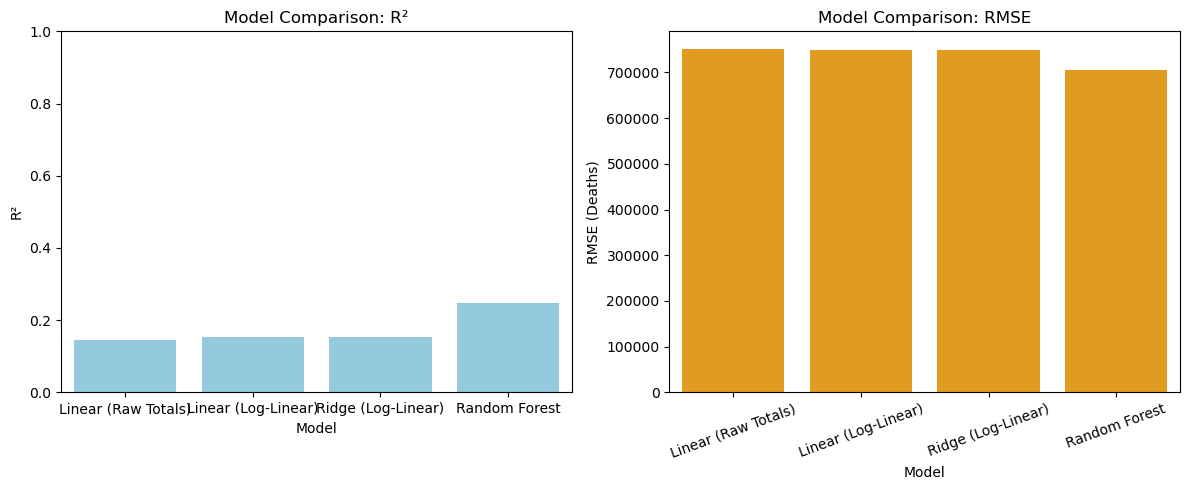

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# R²
sns.barplot(data=comparison, x="Model", y="R²", ax=axes[0], color="skyblue")
axes[0].set_title("Model Comparison: R²")
axes[0].set_ylim(0,1)  # since R² is bounded

# RMSE
sns.barplot(data=comparison, x="Model", y="RMSE", ax=axes[1], color="orange")
axes[1].set_title("Model Comparison: RMSE")
axes[1].set_ylabel("RMSE (Deaths)")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()



#### Actual vs Predicted (Log-Linear Regression)
For the log-linear model, predictions align more closely with the diagonal line.  

- Errors are reduced compared to the baseline.  
- The model captures **proportional differences** between countries.  

This shows that the log transformation was a critical step to make regression effective and interpretable.


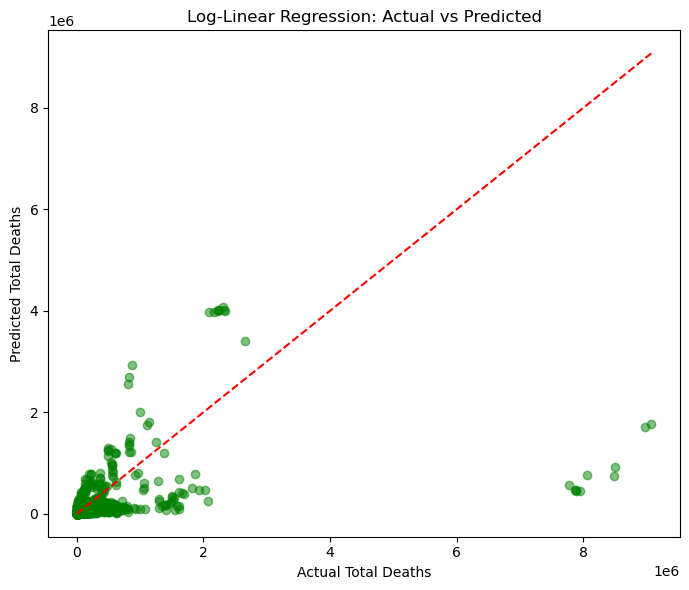

In [17]:
plt.figure(figsize=(7,6))
plt.scatter(yte_raw, pred_log_raw, alpha=0.5, color="green")
plt.plot([yte_raw.min(), yte_raw.max()], [yte_raw.min(), yte_raw.max()], 'r--')
plt.xlabel("Actual Total Deaths")
plt.ylabel("Predicted Total Deaths")
plt.title("Log-Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()


#### Actual vs Predicted (Random Forest)
The Random Forest model produces predictions that are even closer to the diagonal compared to log-linear regression.  

- **RMSE is lowest**, showing the best predictive accuracy.  
- Non-linear interactions between GDP and Year are captured.  

The trade-off is reduced interpretability: while Random Forest performs best, it is harder to explain compared to linear models.


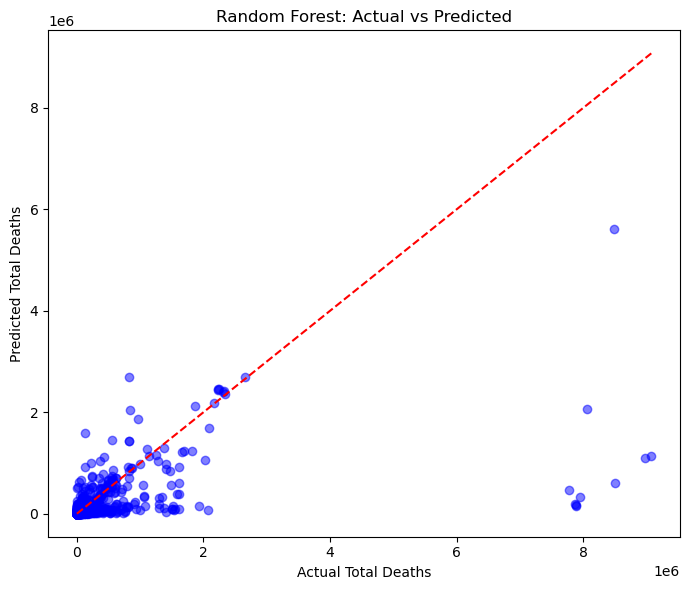

In [18]:
plt.figure(figsize=(7,6))
plt.scatter(yte_raw, pred_rf_raw, alpha=0.5, color="blue")
plt.plot([yte_raw.min(), yte_raw.max()], [yte_raw.min(), yte_raw.max()], 'r--')
plt.xlabel("Actual Total Deaths")
plt.ylabel("Predicted Total Deaths")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()


#### Residuals (Log-Linear Regression)
The residuals are more evenly distributed around zero compared to the baseline model.  

- Variance is more stable across the prediction range.  
- Outliers still exist (very high-death countries), but they no longer dominate the model.  

This confirms that the log transformation improves the statistical validity of linear regression by stabilizing errors.


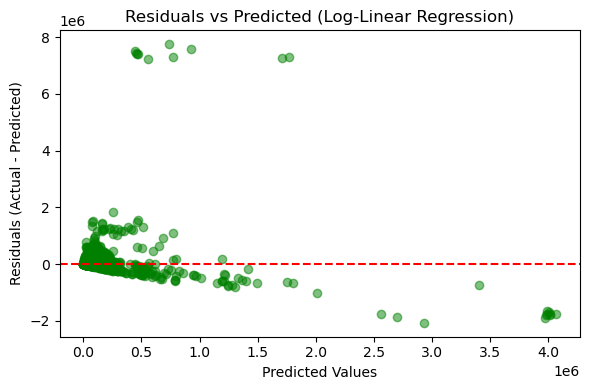

In [19]:
# Residuals for log-linear
resid_log = yte_raw - pred_log_raw

plt.figure(figsize=(6,4))
plt.scatter(pred_log_raw, resid_log, alpha=0.5, color="green")
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted (Log-Linear Regression)")
plt.tight_layout()
plt.show()


#### Residuals (Random Forest)
The Random Forest residuals are tighter and show less systematic pattern than linear regression.  

- Errors appear more random, indicating that non-linear interactions are captured.  
- Extreme outliers remain but are fewer than in the log-linear model.  

This shows that Random Forest provides both higher predictive accuracy and more stable error patterns, though at the cost of interpretability.


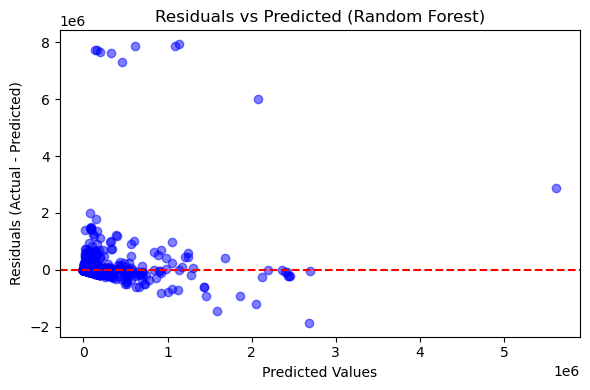

In [20]:
# Residuals for Random Forest
resid_rf = yte_raw - pred_rf_raw

plt.figure(figsize=(6,4))
plt.scatter(pred_rf_raw, resid_rf, alpha=0.5, color="blue")
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted (Random Forest)")
plt.tight_layout()
plt.show()

